# Disciplines

In [2]:
from gemseo_oad_training.models import aerodynamic
from gemseo_oad_training.models import approach
from gemseo_oad_training.models import battery
from gemseo_oad_training.models import climb
from gemseo_oad_training.models import engine
from gemseo_oad_training.models import fuel_tank
from gemseo_oad_training.models import geometry
from gemseo_oad_training.models import mass
from gemseo_oad_training.models import mission
from gemseo_oad_training.models import operating_cost
from gemseo_oad_training.models import take_off
from gemseo_oad_training.models import total_mass

from gemseo.scenarios.mdo_scenario import MDOScenario


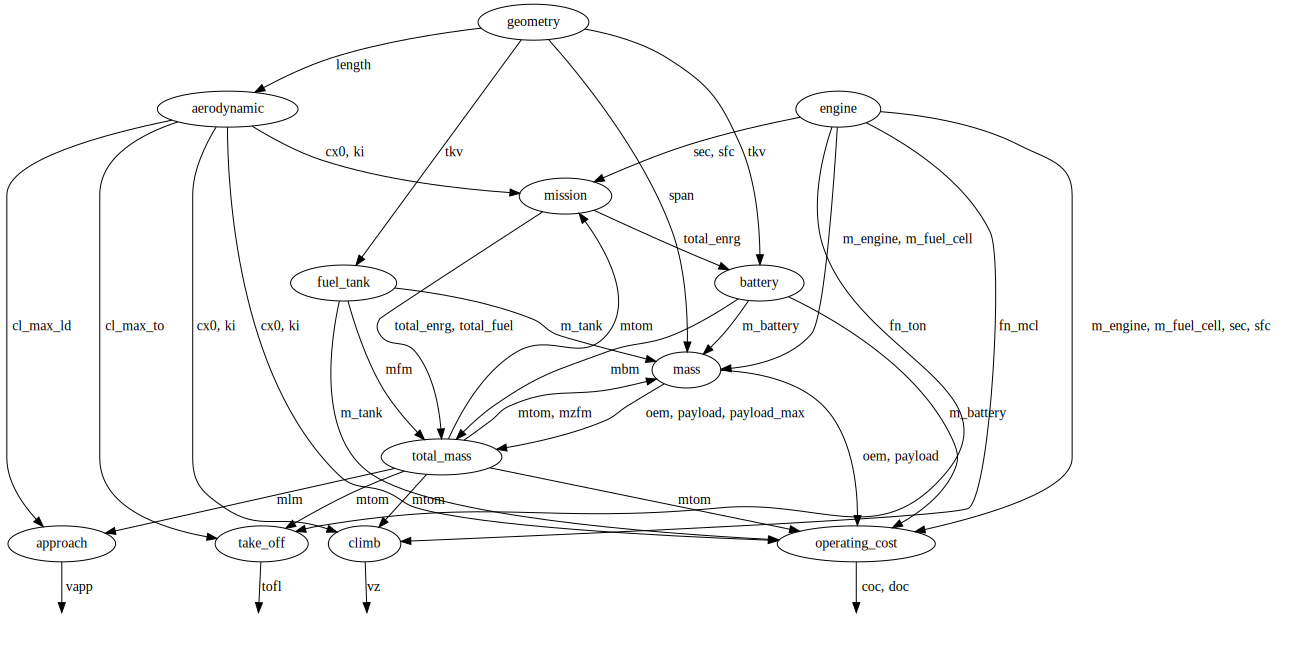

In [3]:
from gemseo.disciplines.auto_py import AutoPyDiscipline
from gemseo import generate_coupling_graph

discipline_aerodynamic = AutoPyDiscipline(aerodynamic)
discipline_approach = AutoPyDiscipline(approach)
discipline_battery = AutoPyDiscipline(battery)
discipline_climb = AutoPyDiscipline(climb)
discipline_engine = AutoPyDiscipline(engine)
discipline_fuel_tank = AutoPyDiscipline(fuel_tank)
discipline_geometry = AutoPyDiscipline(geometry)
discipline_mass = AutoPyDiscipline(mass)
discipline_mission = AutoPyDiscipline(mission)
discipline_operating_cost = AutoPyDiscipline(operating_cost)
discipline_take_off = AutoPyDiscipline(take_off)
discipline_total_mass = AutoPyDiscipline(total_mass)

disciplines = [discipline_aerodynamic, 
               discipline_approach,
               discipline_battery, 
               discipline_climb, 
               discipline_engine,
               discipline_fuel_tank,
               discipline_geometry,
               discipline_mass, 
               discipline_mission,
               discipline_operating_cost,
               discipline_take_off,
               discipline_total_mass]

generate_coupling_graph(disciplines, file_path="")

# Design space

In [4]:
from gemseo import configure_logger
from gemseo.algos.design_space import DesignSpace
from gemseo.disciplines.analytic import AnalyticDiscipline
from gemseo.scenarios.doe_scenario import DOEScenario
configure_logger()

<RootLogger root (INFO)>

In [5]:
from gemseo_oad_training.unit import convert_from
from gemseo.algos.parameter_space import ParameterSpace

uncertain_space = ParameterSpace()
uncertain_space.add_variable("slst", value=convert_from("kN",150))
uncertain_space.add_variable("n_pax", value=150.0)
uncertain_space.add_variable("area", value=180.0)
uncertain_space.add_variable("ar", value=9.0)


uncertain_space.add_random_variable("gi","OTTriangularDistribution", minimum=0.35, mode=0.4, maximum=0.405)
uncertain_space.add_random_variable("vi","OTTriangularDistribution", minimum=0.755, mode=0.800, maximum=0.805)
uncertain_space.add_random_variable("aef","OTTriangularDistribution", minimum=0.99, mode=1., maximum=1.03)
uncertain_space.add_random_variable("cef","OTTriangularDistribution", minimum=0.99, mode=1., maximum=1.03)
uncertain_space.add_random_variable("sef","OTTriangularDistribution", minimum=0.99, mode=1., maximum=1.03)

scenario = MDOScenario(disciplines, "mtom", uncertain_space, formulation_name="MDF")

In [6]:
scenario.add_constraint("tofl", constraint_type="ineq", positive=False, value=1900.)
scenario.add_constraint("vapp", constraint_type="ineq", positive=False, value=convert_from("kt", 135))
scenario.add_constraint("vz", constraint_type="ineq", positive=True, value=convert_from("ft/min", 300))
scenario.add_constraint("span", constraint_type="ineq", positive=False, value=40.)
scenario.add_constraint("length", constraint_type="ineq", positive=False, value=45.)
scenario.add_constraint("fm", constraint_type="ineq", positive=True, value=0.)


In [7]:
scenario.execute(algo_name="NLOPT_COBYLA", max_iter=100)


    INFO - 15:08:40: *** Start MDOScenario execution ***
    INFO - 15:08:40: MDOScenario
    INFO - 15:08:40:    Disciplines: aerodynamic approach battery climb engine fuel_tank geometry mass mission operating_cost take_off total_mass
    INFO - 15:08:40:    MDO formulation: MDF
    INFO - 15:08:40: Optimization problem:
    INFO - 15:08:40:    minimize mtom(slst, n_pax, area, ar, gi, vi, aef, cef, sef)
    INFO - 15:08:40:    with respect to aef, ar, area, cef, gi, n_pax, sef, slst, vi
    INFO - 15:08:40:    subject to constraints:
    INFO - 15:08:40:       tofl(slst, n_pax, area, ar, gi, vi, aef, cef, sef) <= 1900.0
    INFO - 15:08:40:       vapp(slst, n_pax, area, ar, gi, vi, aef, cef, sef) <= 69.44999999400001
    INFO - 15:08:40:       vz(slst, n_pax, area, ar, gi, vi, aef, cef, sef) >= 1.524
    INFO - 15:08:40:       span(slst, n_pax, area, ar, gi, vi, aef, cef, sef) <= 40.0
    INFO - 15:08:40:       length(slst, n_pax, area, ar, gi, vi, aef, cef, sef) <= 45.0
    INFO - 15

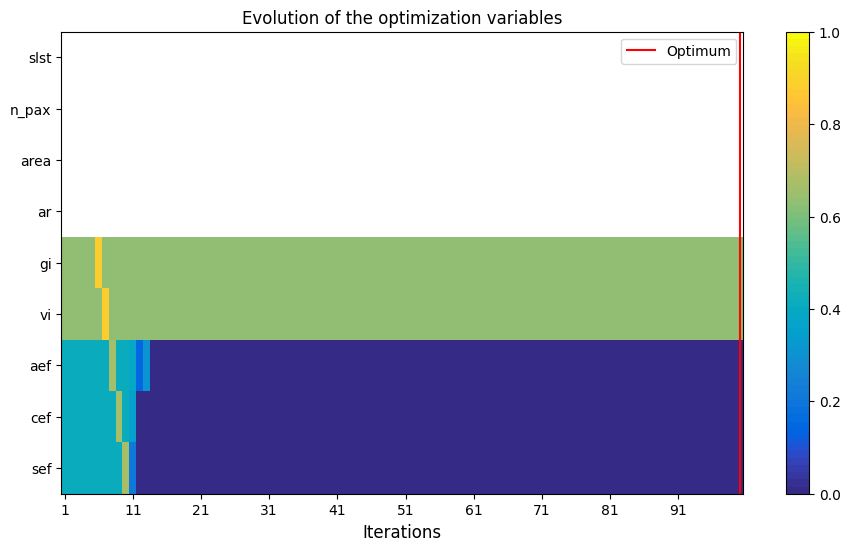

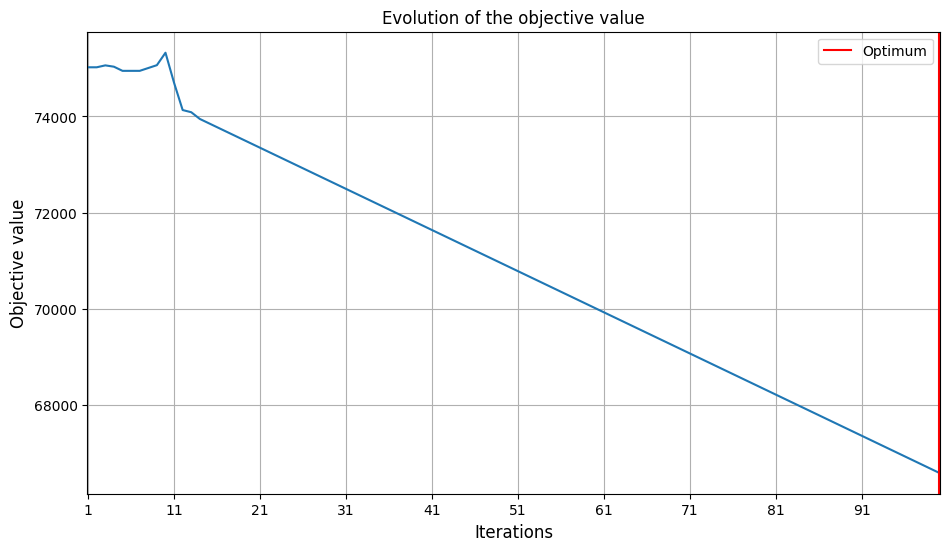

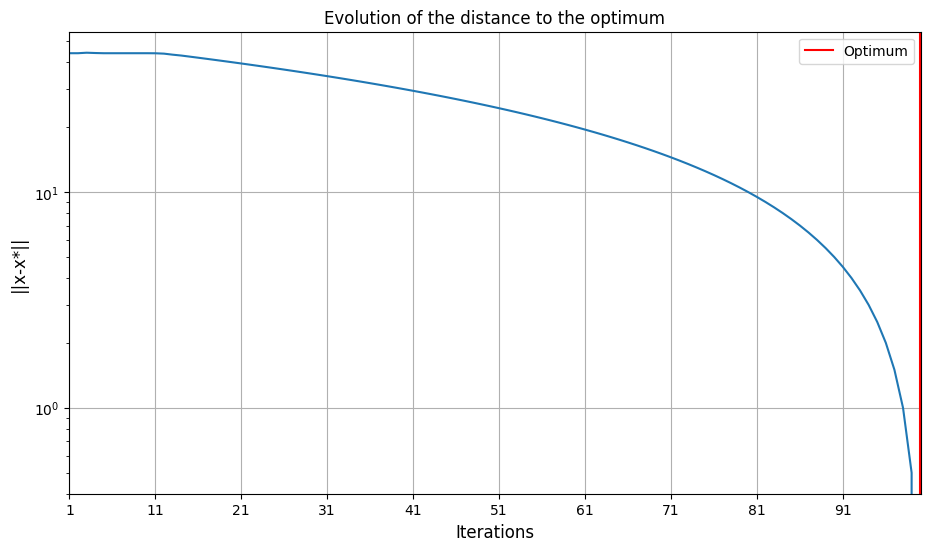

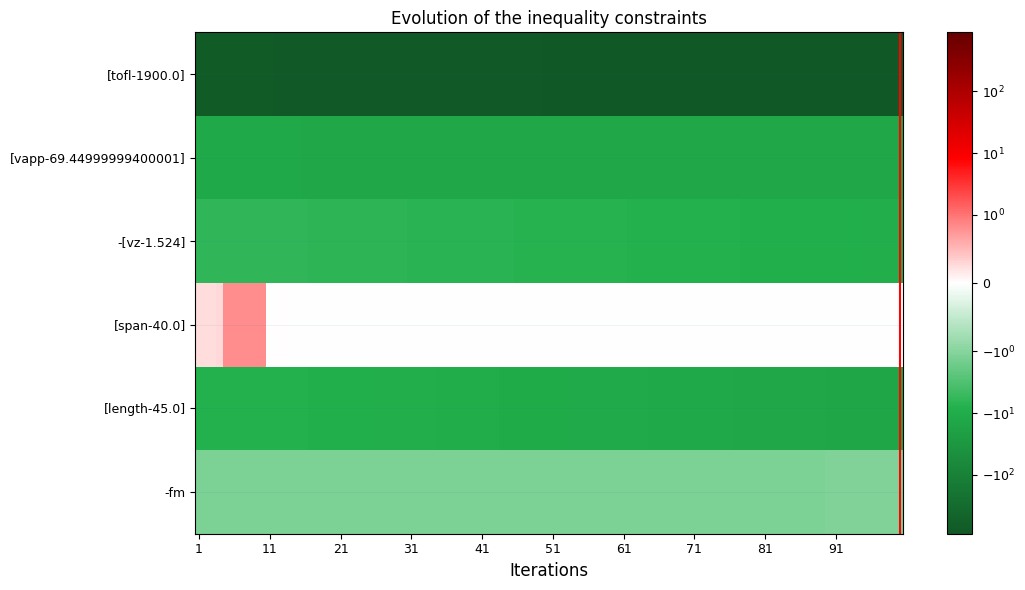

In [8]:
scenario.post_process(post_name="OptHistoryView", save=False, show=True)

In [9]:
from numpy import array

from gemseo import from_pickle
from gemseo import sample_disciplines
from gemseo import to_pickle
from gemseo.algos.design_space import DesignSpace
from gemseo.disciplines.analytic import AnalyticDiscipline
from gemseo.disciplines.surrogate import SurrogateDiscipline

training_dataset = sample_disciplines(disciplines, uncertain_space, ["tofl", "vapp", "vz", "span", "length","fm"], algo_name="OT_OPT_LHS", n_samples=20)
test_dataset = sample_disciplines(disciplines, uncertain_space, ["tofl", "vapp", "vz", "span", "length","fm"], algo_name="OT_FULLFACT", n_samples=30)

    INFO - 15:08:43: *** Start Sampling execution ***
    INFO - 15:08:43: Sampling
    INFO - 15:08:43:    Disciplines: aerodynamic approach battery climb engine fuel_tank geometry mass mission operating_cost take_off total_mass
    INFO - 15:08:43:    MDO formulation: MDF
    INFO - 15:08:43: Running the algorithm OT_OPT_LHS:
    INFO - 15:08:44:    100%|██████████| 20/20 [00:00<00:00, 34.58 it/sec]
    INFO - 15:08:44: *** End Sampling execution (time: 0:00:00.586689) ***
    INFO - 15:08:44: *** Start Sampling execution ***
    INFO - 15:08:44: Sampling
    INFO - 15:08:44:    Disciplines: aerodynamic approach battery climb engine fuel_tank geometry mass mission operating_cost take_off total_mass
    INFO - 15:08:44:    MDO formulation: MDF
    INFO - 15:08:44: Running the algorithm OT_FULLFACT:
    INFO - 15:08:44:    100%|██████████| 1/1 [00:00<00:00, 67.44 it/sec]oes not exist; use 1 samples instead, i.e. the largest 9-th integer power less than 30.
    INFO - 15:08:44: *** End 

In [10]:
surrogate_discipline = SurrogateDiscipline("RBFRegressor", training_dataset)

In [12]:
rmse = surrogate_discipline.get_error_measure("RMSEMeasure")
rmse.compute_learning_measure(as_dict=True)

{'fm': array([7.85046229e-17]),
 'length': array([1.25607397e-15]),
 'span': array([3.14462832e-16]),
 'tofl': array([0.01626451]),
 'vapp': array([1.40594127e-12]),
 'vz': array([1.58841507e-12])}

In [13]:
rmse.compute_test_measure(test_dataset, as_dict=True)


{'fm': array([6.47215696e-06]),
 'length': array([0.0016642]),
 'span': array([0.07044881]),
 'tofl': array([3.87786215e+11]),
 'vapp': array([113.46335215]),
 'vz': array([177.27564947])}

In [17]:
r2 = surrogate_discipline.get_error_measure("R2Measure")
r2.compute_learning_measure(as_dict=True)

{'fm': array([0.99931321]),
 'length': array([0.99946174]),
 'span': array([0.99825792]),
 'tofl': array([0.99605677]),
 'vapp': array([0.99803913]),
 'vz': array([0.99796532])}

In [18]:
r2.compute_cross_validation_measure(as_dict=True)

{'fm': array([0.91579294]),
 'length': array([0.90363941]),
 'span': array([0.78673609]),
 'tofl': array([-0.21627731]),
 'vapp': array([-0.11782615]),
 'vz': array([0.22896498])}